# Exploratory Data Analysis and Modelling for Credit Risk Prediction

***
### Table of Content

1. Introduction
        1.1 Setup

2. Exploratory Data Analysis for Customer Data
        2.1 Check for Duplicatd Data
        2.2 Data Distribution
        2.3 Correlation Matrix
        2.4 Model Performance Based on Customer Data (Baseline) 


3. Exploratory Data Analysis for Customer Payment History
        3.1 Feature Engineering
        3.2 Data Distribution
        3.3 Correlation Matrix
        3.4 Model Performance Based on Customer and Payment Data

4. Modelling
        4.1 Hyperparameter Optimisation
        4.2 Final Model
        
***

# 1. Introduction

The purpose of this notebook is to conduct an Exploratory Data Analysis (EDA) on the given customer features and payment history to obtain useful insights. Features would be built from the existing data and a model would be developed to predict the credit risk of customers. 

## 1.1 Setup

In [39]:
import os
import warnings
warnings.filterwarnings('ignore')

#data handling
import numpy as np
import pandas as pd
from collections import Counter

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold, cross_val_score, ShuffleSplit, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_recall_fscore_support, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline



# 2. Exploratory Data Analysis for Customer Data


In [2]:
filepath = os.getcwd()
customer = pd.read_csv(filepath+"/customer_data_ratio20.csv")
customer.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [3]:
customer.shape

(1125, 13)

"customer_data.csv" has been provided which contains customer’s demographic data and category attributes which have been encoded. Category features are fea_1, fea_3, fea_5, fea_6, fea_7, fea_9. If label is 1, the customer has high credit risk.

The given customer dataset contains 1125 rows of data with 11 features and corresponding credit risk. 

In [4]:
customer.dtypes

label       int64
id          int64
fea_1       int64
fea_2     float64
fea_3       int64
fea_4     float64
fea_5       int64
fea_6       int64
fea_7       int64
fea_8       int64
fea_9       int64
fea_10      int64
fea_11    float64
dtype: object

- Categorical Features: fea_1, fea_3, fea_5, fea_6, fea_7, fea_9, label
- Continuous Numerical Features: fea_2, fea_4, fea_8, fea_10, fea_11

## 2.1 Check for Duplicated Data

In [5]:
customer['id'].nunique()

1125

There is no duplicated customer id in the given data. 

## 2.2 Data Distribution

In [6]:
customer.describe()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
count,1125.000000,1.125000e+03,1125.000000,976.000000,1125.000000,1.125000e+03,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,0.200000,5.783677e+07,5.482667,1283.911373,2.333333,1.208836e+05,1.928889,10.872000,4.832889,100.802667,4.195556,164618.495111,134.999004
std,0.400178,1.817150e+06,1.383338,51.764022,0.878773,8.844523e+04,0.257125,2.676437,2.971182,11.988955,0.855679,152520.488281,112.616798
min,0.000000,5.498235e+07,1.000000,1116.500000,1.000000,1.500000e+04,1.000000,3.000000,-1.000000,64.000000,1.000000,60000.000000,1.000000
25%,0.000000,5.499050e+07,4.000000,1244.000000,1.000000,7.200000e+04,2.000000,8.000000,5.000000,90.000000,3.000000,60044.000000,1.000000
50%,0.000000,5.898975e+07,5.000000,1281.500000,3.000000,1.020000e+05,2.000000,11.000000,5.000000,105.000000,4.000000,72000.000000,173.205081
75%,0.000000,5.899799e+07,7.000000,1314.500000,3.000000,1.390000e+05,2.000000,11.000000,5.000000,111.000000,5.000000,151307.000000,202.484567
max,1.000000,5.900624e+07,7.000000,1481.000000,3.000000,1.200000e+06,2.000000,16.000000,10.000000,115.000000,5.000000,650070.000000,707.106781


fea_2 in the given customer dataset contains 149 missing values which will be addressed subsequently. 

In [7]:
customer.label.value_counts()

0    900
1    225
Name: label, dtype: int64

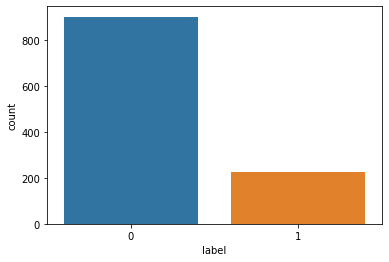

In [8]:
ax = sns.countplot(x="label", data=customer)

The dataset is imbalanced where 20% of the customers have high credit risk.

An imbalanced dataset could affect the performance of the model. A number of measures can be taken to tackle this potential issue: 
- Collect more data. This is not possible in this case. 
- Selecting an appropriate performance metric. Accuracy would not be useful as a model which blindly predicts 0 all the time would be correct about 80% of the time. 
- Resampling data. Over-sampling of the minority class can be done to reduce the imbalanced ratio between both classes.  

We will explore the above measures subsequently. 

Let's explore the distribution of the categorical features. 

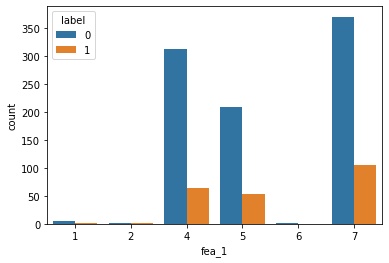

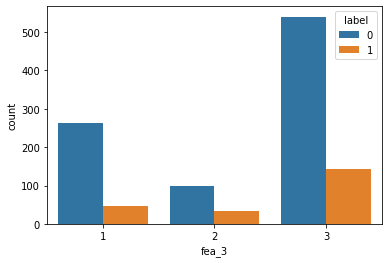

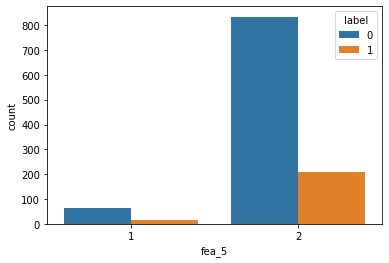

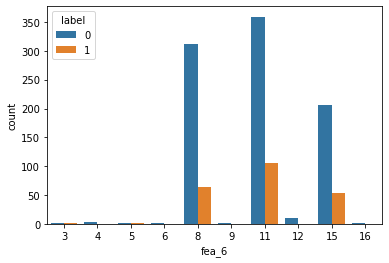

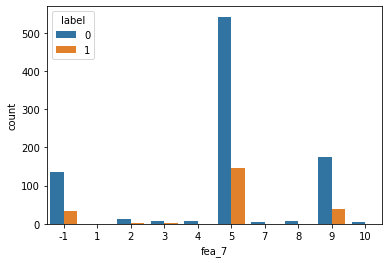

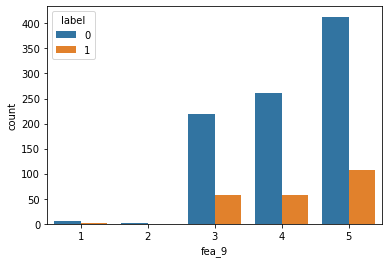

In [9]:
category = ['fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_7', 'fea_9']
for i, col in enumerate(category):
    plt.figure(i)
    ax = sns.countplot(x=col, hue="label", data=customer)

Let's explore the continuous numerical features. Before we address the missing values in fea_2, let's take a look at the distribution of the existing values. 

Text(0.5, 1.0, 'fea_2')

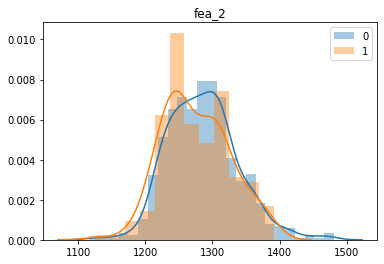

In [10]:
fea2 = customer.dropna()
label0 = fea2.loc[fea2['label']==0]
label1 = fea2.loc[fea2['label']==1]
plt.figure()
ax = sns.distplot(label0[['fea_2']], label='0')
ax = sns.distplot(label1[['fea_2']], label='1')
plt.legend()
ax.set_title('fea_2')

To address the missing values in fea_2, let's impute them with the mean of fea_2. 

In [11]:
customer['fea_2m'] = customer['fea_2']
customer['fea_2m'] = customer['fea_2m'].fillna(customer['fea_2m'].mean())

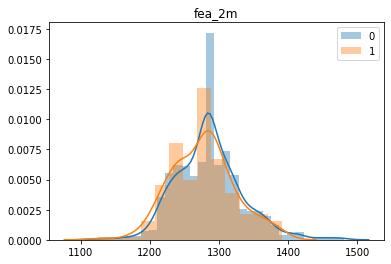

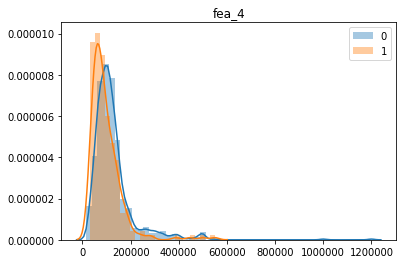

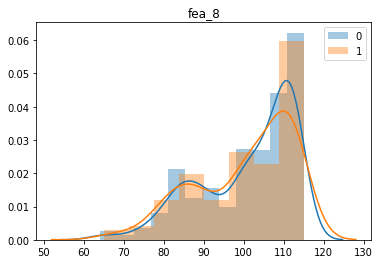

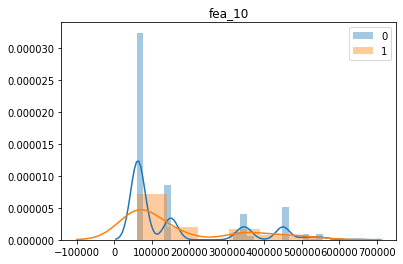

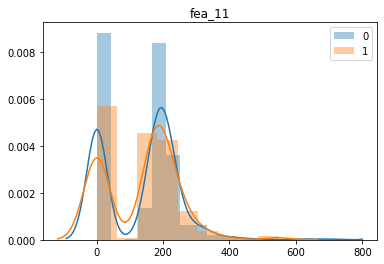

In [12]:
continuous = ['fea_2m', 'fea_4', 'fea_8', 'fea_10', 'fea_11']
for i, col in enumerate(continuous):
    label0 = customer.loc[customer['label']==0]
    label1 = customer.loc[customer['label']==1]
    plt.figure(i)
    ax = sns.distplot(label0[[col]], label='0')
    ax = sns.distplot(label1[[col]], label='1')
    plt.legend()
    ax.set_title(col)

## 2.3 Correlation Matrix

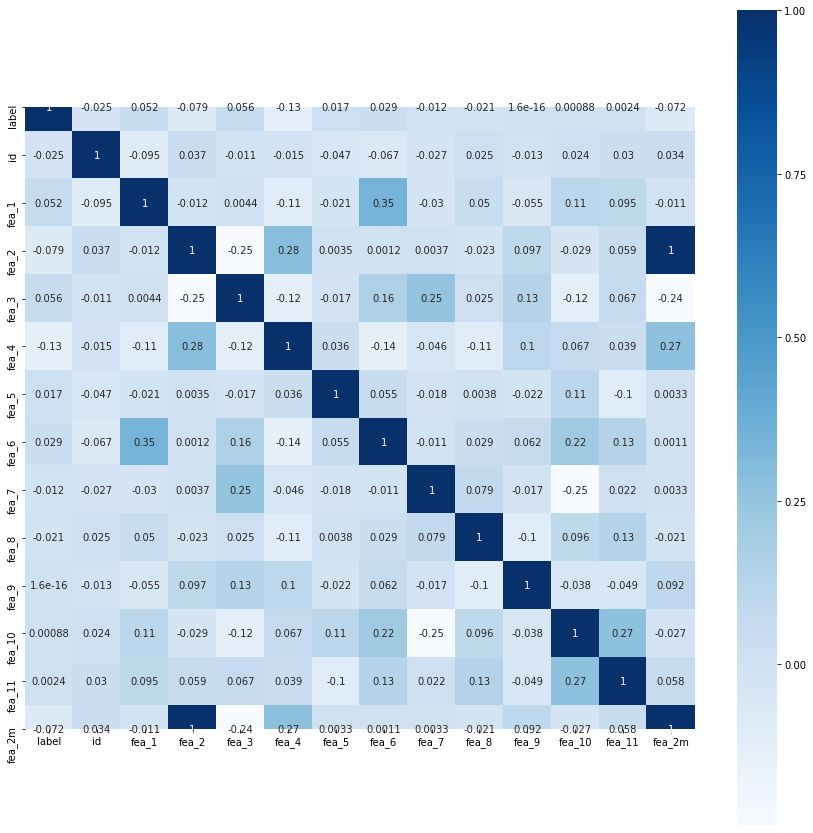

In [13]:
plt.figure(figsize=(15,15))
sns.heatmap(customer.corr(), square=True, annot=True, cmap="Blues")

Based on the correlation matrix above, it can be seen that the following features have a relatively higher correlation with 'label':
- fea_4
- fea_2/fea_2m
- fea_3
- fea_1

## 2.4 Model Performance Based on Customer Data (Baseline) 

To set a benchmark for the purpose of evaluating the impact of improvements on the performance of the model, RandomForestClassifier has been chosen as it is able to perform fairly well without scaling the data. 

In [14]:
def test(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_leaf_nodes=5, random_state=0)
    rf.fit(X_train, y_train)
    y_pred_train = rf.predict_proba(X_train)
    y_pred_test = rf.predict_proba(X_test)
    score_auc_train = roc_auc_score(y_train, y_pred_train[:,1])
    score_auc_test = roc_auc_score(y_test, y_pred_test[:,1])
    score_train = classification_report(y_train, y_pred_train[:,1].round())
    score_test = classification_report(y_test, y_pred_test[:,1].round())
    #fpr1, tpr1, thresh1 = roc_curve(y_val, y_pred, pos_label=1)
    #plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='RF')
    print("Training ROC_AUC Score: {:.3f}".format(score_auc_train))
    print("Training Classification Report: \n{}".format(score_train))
    print("Testing ROC_AUC Score: {:.3f}".format(score_auc_test))
    print("Testing Classification Report: \n{}".format(score_test))
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::1]
    names = [X.columns[i] for i in indices]

    plt.barh(range(X.shape[1]), importances[indices])
    plt.yticks(range(X.shape[1]), names, rotation=20, fontsize = 8)
    plt.title("Feature Importance")
    plt.figure(figsize=(30,30))
    plt.show()

Training ROC_AUC Score: 0.738
Training Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       674
           1       0.00      0.00      0.00       169

    accuracy                           0.80       843
   macro avg       0.40      0.50      0.44       843
weighted avg       0.64      0.80      0.71       843

Testing ROC_AUC Score: 0.555
Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       226
           1       0.00      0.00      0.00        56

    accuracy                           0.80       282
   macro avg       0.40      0.50      0.44       282
weighted avg       0.64      0.80      0.71       282



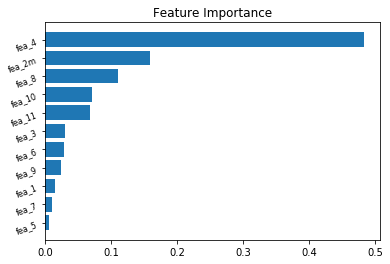

<Figure size 2160x2160 with 0 Axes>

In [15]:
X = customer.drop(['label', 'id', 'fea_2'], axis=1)
y = customer['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
test(X_train, X_test, y_train, y_test)

The above results will form the baseline to evaluate any subsequent improvements to the model. As can be seen above, there are signs of overfitting the training data as the ROC_AUC score is higher on the training data as compared to the test data. As mentioned previously, accuracy would not be a useful performance metric as 80% accuracy has been achieved in both training and test data, which is the representation of majority class in the data set. 

Training ROC_AUC Score: 0.862
Training Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       674
           1       0.81      0.77      0.79       674

    accuracy                           0.79      1348
   macro avg       0.80      0.79      0.79      1348
weighted avg       0.80      0.79      0.79      1348

Testing ROC_AUC Score: 0.631
Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       226
           1       0.29      0.32      0.30        56

    accuracy                           0.71       282
   macro avg       0.56      0.56      0.56       282
weighted avg       0.72      0.71      0.71       282



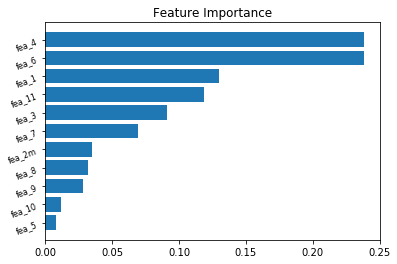

<Figure size 2160x2160 with 0 Axes>

In [16]:
over = SMOTE(sampling_strategy=1)
X_over, y_over = over.fit_resample(X_train, y_train)
test(X_over, X_test, y_over, y_test)

As seen above, oversampling of the minority class has helped to improve the ROC_AUC score for both training and test data. The recall score for the test data has also improved, which is important as we would like to minimise the probability of false negative which would have a cost impact on the bank. The f1-score has also improved, indicating that the precision has improved with the recall. 

# 3. Exploratory Data Analysis for Customer Payment History Data

"payment_data.csv" has been provided which contains customer’s card payment history with the following information:
	- id: customer id
	- OVD_t1: number of times overdue type 1
	- OVD_t2: number of times overdue type 2
	- OVD_t3: number of times overdue type 3
	- OVD_sum: total overdue days
	- pay_normal: number of times normal payment
	- prod_code: credit product code
	- prod_limit: credit limit of product
	- update_date: account update date
	- new_balance: current balance of product
	- highest_balance: highest balance in history
	- report_date: date of recent payment

In [17]:
payment = pd.read_csv(filepath+"/payment_data_ratio20.csv")
payment.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016


In [18]:
payment.shape

(8250, 12)

In [19]:
payment['id'].nunique()

1125

The given customer payment history dataset contains 8250 rows of data with 11 features. Since there are 1125 unique id values, there could be repeated payments captured for each customer. 

In [20]:
payment.dtypes

id                   int64
OVD_t1               int64
OVD_t2               int64
OVD_t3               int64
OVD_sum              int64
pay_normal           int64
prod_code            int64
prod_limit         float64
update_date         object
new_balance        float64
highest_balance    float64
report_date         object
dtype: object

In [21]:
payment.isnull().sum()

id                    0
OVD_t1                0
OVD_t2                0
OVD_t3                0
OVD_sum               0
pay_normal            0
prod_code             0
prod_limit         6118
update_date          26
new_balance           0
highest_balance     409
report_date        1114
dtype: int64

There is a significant number of missing values for prod_limit. 

In [22]:
payment.describe()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,new_balance,highest_balance
count,8.250000e+03,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,2132.000000,8.250000e+03,7.841000e+03
mean,5.782173e+07,0.249091,0.127152,0.369212,187.681697,14.526667,8.232000,85789.702205,1.054042e+05,2.192027e+05
std,1.822724e+06,1.250197,0.860046,2.900320,1804.232570,12.053627,3.533055,74345.828184,1.887704e+06,2.814536e+06
min,5.498235e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,-4.030320e+04,5.010000e+02
25%,5.499050e+07,0.000000,0.000000,0.000000,0.000000,4.000000,6.000000,37400.000000,0.000000e+00,2.345300e+04
50%,5.898905e+07,0.000000,0.000000,0.000000,0.000000,11.000000,10.000000,68200.000000,0.000000e+00,4.404700e+04
75%,5.899655e+07,0.000000,0.000000,0.000000,0.000000,25.000000,10.000000,112200.000000,2.494800e+04,1.005000e+05
max,5.900624e+07,34.000000,34.000000,35.000000,31500.000000,36.000000,27.000000,660000.000000,1.632120e+08,1.800005e+08


## 3.1 Feature Engineering

In [23]:
#When the new balance is greater than the previous highest balance, this could potentially be a sign of credit risk. 
payment['balance_increase'] = payment['new_balance']-payment['highest_balance']

#Though there is a significant number of missing beyond_limit values, there could be potential credit risk if the highest balance is greater than the product limit. 
payment['beyond_limit'] = payment['highest_balance']-payment['prod_limit']
#The number of times where the highest balance exceeds the credit limit could also be a sign of potential credit risk. 
payment['beyond_limit_num'] = payment['beyond_limit']
payment['beyond_limit_num'] = payment['beyond_limit_num'].apply(lambda x: 1 if x>0 else 0)
payment['beyond_limit'] = payment['beyond_limit'].apply(lambda x: x if x>0 else 0)

#The number and type of product could also be a potential feature to facilitate the prediction of credit risk. 
payment = pd.get_dummies(payment, columns=['prod_code'])
payment

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_limit,update_date,new_balance,highest_balance,...,prod_code_12,prod_code_13,prod_code_15,prod_code_17,prod_code_19,prod_code_22,prod_code_24,prod_code_25,prod_code_26,prod_code_27
0,58987402,0,0,0,0,1,16500.0,04/12/2016,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,58995151,0,0,0,0,1,NaN,04/12/2016,588720.0,491100.0,...,0,0,0,0,0,0,0,0,0,0
2,58997200,0,0,0,0,2,NaN,04/12/2016,840000.0,700500.0,...,0,0,0,0,0,0,0,0,0,0
3,54988608,0,0,0,0,3,37400.0,03/12/2016,8425.2,7520.0,...,0,0,0,0,0,0,0,0,0,0
4,54987763,0,0,0,0,2,NaN,03/12/2016,15147.6,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8245,58995478,0,0,0,0,9,NaN,NaN,0.0,NaN,...,0,0,1,0,0,0,0,0,0,0
8246,54992408,0,0,0,0,1,NaN,NaN,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
8247,54988209,0,0,0,0,5,NaN,NaN,20654.4,33315.0,...,0,1,0,0,0,0,0,0,0,0
8248,54992408,0,0,0,0,1,NaN,NaN,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Drop prod_limit as there are too many missing values and report_date which is unlikely to be useful.
# Group the data by id and then aggregate the respective data by count, mean and sum.
payment_agg = payment.drop(columns = ['prod_limit', 'report_date']).groupby('id', as_index=False).agg(['count', 'mean', 'sum']).reset_index()
payment_agg.head()

id OVD_t1               OVD_t2               OVD_t3                \
             count      mean sum  count      mean sum  count      mean sum   
0  54982353     18  0.166667   3     18  0.111111   2     18  2.111111  38   
1  54982356      7  0.000000   0      7  0.000000   0      7  0.000000   0   
2  54982387     11  0.272727   3     11  0.000000   0     11  0.000000   0   
3  54982463      2  0.000000   0      2  0.000000   0      2  0.000000   0   
4  54982530      4  0.000000   0      4  0.000000   0      4  0.000000   0   

   ... prod_code_24 prod_code_25          prod_code_26          prod_code_27  \
   ...          sum        count mean sum        count mean sum        count   
0  ...            0           18  0.0   0           18  0.0   0           18   
1  ...            0            7  0.0   0            7  0.0   0            7   
2  ...            0           11  0.0   0           11  0.0   0           11   
3  ...            0            2  0.0   0            2  0.0   0            2   
4  ...            0            4  0.0   0            4  0.0   0            4   

                 
       mean sum  
0  0.000000   0  
1  0.285714   2  
2  0.000000   0  
3  0.000000   0  
4  0.000000   0  

[5 rows x 94 columns]

In [25]:
#collapse the 2-level header for ease of handling
columns = ['id']
for name in payment_agg.columns.levels[0]:
    if name != 'id':
        for stat in payment_agg.columns.levels[1][:-1]:
            columns.append('%s_%s' % (name,stat))
payment_agg.columns = columns
payment_agg.columns

Index(['id', 'OVD_t1_count', 'OVD_t1_mean', 'OVD_t1_sum', 'OVD_t2_count',
       'OVD_t2_mean', 'OVD_t2_sum', 'OVD_t3_count', 'OVD_t3_mean',
       'OVD_t3_sum', 'OVD_sum_count', 'OVD_sum_mean', 'OVD_sum_sum',
       'pay_normal_count', 'pay_normal_mean', 'pay_normal_sum',
       'new_balance_count', 'new_balance_mean', 'new_balance_sum',
       'highest_balance_count', 'highest_balance_mean', 'highest_balance_sum',
       'balance_increase_count', 'balance_increase_mean',
       'balance_increase_sum', 'beyond_limit_count', 'beyond_limit_mean',
       'beyond_limit_sum', 'beyond_limit_num_count', 'beyond_limit_num_mean',
       'beyond_limit_num_sum', 'prod_code_0_count', 'prod_code_0_mean',
       'prod_code_0_sum', 'prod_code_1_count', 'prod_code_1_mean',
       'prod_code_1_sum', 'prod_code_2_count', 'prod_code_2_mean',
       'prod_code_2_sum', 'prod_code_3_count', 'prod_code_3_mean',
       'prod_code_3_sum', 'prod_code_4_count', 'prod_code_4_mean',
       'prod_code_4_sum', 'pro

In [26]:
#The number of overdue events and overdue rate could potentially be useful features to facilitate credit risk prediction. 
payment_agg['OVD_count'] = payment_agg['OVD_t1_sum']+payment_agg['OVD_t2_sum']+payment_agg['OVD_t3_sum']
payment_agg['OVD_rate']=(payment_agg['OVD_count']/(payment_agg['OVD_count']+payment_agg['pay_normal_sum']))
payment_agg

,id,OVD_t1_count,OVD_t1_mean,OVD_t1_sum,OVD_t2_count,OVD_t2_mean,OVD_t2_sum,OVD_t3_count,OVD_t3_mean,OVD_t3_sum,...,prod_code_25_mean,prod_code_25_sum,prod_code_26_count,prod_code_26_mean,prod_code_26_sum,prod_code_27_count,prod_code_27_mean,prod_code_27_sum,OVD_count,OVD_rate
0,54982353,18,0.166667,3,18,0.111111,2,18,2.111111,38,...,0.0,0,18,0.0,0,18,0.000000,0,43,0.158088
1,54982356,7,0.000000,0,7,0.000000,0,7,0.000000,0,...,0.0,0,7,0.0,0,7,0.285714,2,0,0.000000
2,54982387,11,0.272727,3,11,0.000000,0,11,0.000000,0,...,0.0,0,11,0.0,0,11,0.000000,0,3,0.012048
3,54982463,2,0.000000,0,2,0.000000,0,2,0.000000,0,...,0.0,0,2,0.0,0,2,0.000000,0,0,0.000000
4,54982530,4,0.000000,0,4,0.000000,0,4,0.000000,0,...,0.0,0,4,0.0,0,4,0.000000,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,59005995,3,0.000000,0,3,0.000000,0,3,0.000000,0,...,0.0,0,3,0.0,0,3,0.000000,0,0,0.000000
1121,59006139,4,0.000000,0,4,0.000000,0,4,0.000000,0,...,0.0,0,4,0.0,0,4,0.000000,0,0,0.000000
1122,59006193,8,0.000000,0,8,0.000000,0,8,0.000000,0,...,0.0,0,8,0.0,0,8,0.000000,0,0,0.000000
1123,59006219,3,0.333333,1,3,0.000000,0,3,0.000000,0,...,0.0,0,3,0.0,0,3,0.000000,0,1,0.012195


In [27]:
# Potentially useful features have been selected from the aggregated payment data. 
# OVD_t1_count has been selected as a proxy to the total number of products for each customer. 
payment_sel = payment_agg[['id', 'OVD_t1_sum', 'OVD_t2_sum', 'OVD_t3_sum', 'OVD_sum_sum', 'pay_normal_sum', 'new_balance_sum', 'new_balance_mean', 'highest_balance_sum', 'OVD_count', 'OVD_t1_count', 'balance_increase_sum', 'beyond_limit_sum', 'beyond_limit_num_sum']]
payment_sel.head()

,id,OVD_t1_sum,OVD_t2_sum,OVD_t3_sum,OVD_sum_sum,pay_normal_sum,new_balance_sum,new_balance_mean,highest_balance_sum,OVD_count,OVD_t1_count,balance_increase_sum,beyond_limit_sum,beyond_limit_num_sum
0,54982353,3,2,38,32078,229,756596.4,42033.133333,3452172.0,43,18,-2709484.8,232853.0,3
1,54982356,0,0,0,0,117,15944.4,2277.771429,1376545.0,0,7,-1360600.6,0.0,0
2,54982387,3,0,0,12,246,1292006.4,117455.127273,2620970.0,3,11,-1328963.6,38473.0,2
3,54982463,0,0,0,0,34,79780.8,39890.400000,157000.0,0,2,-77219.2,0.0,0
4,54982530,0,0,0,0,56,5044.8,1261.200000,51151.0,0,4,-46106.2,0.0,0


In [28]:
# The length of time over which the customer has been using the bank products has been extracted and could be a potential feature. 
payment['update_date'] = pd.to_datetime(payment['update_date'])
date = payment[['id', 'update_date']]
df1 = date.loc[date.groupby('id')['update_date'].idxmin()]
df2 = date.loc[date.groupby('id')['update_date'].idxmax()]
df3 = pd.merge(df1, df2, on ='id')
df3['duration']=df3['update_date_y']-df3['update_date_x']
df3=df3.drop(['update_date_y', 'update_date_x'], axis=1)
df3['duration'] = df3['duration'].apply(lambda x: x.days)

In [29]:
payment_sel = pd.merge(payment_sel, df3, on ='id')
payment_sel.head()

,id,OVD_t1_sum,OVD_t2_sum,OVD_t3_sum,OVD_sum_sum,pay_normal_sum,new_balance_sum,new_balance_mean,highest_balance_sum,OVD_count,OVD_t1_count,balance_increase_sum,beyond_limit_sum,beyond_limit_num_sum,duration
0,54982353,3,2,38,32078,229,756596.4,42033.133333,3452172.0,43,18,-2709484.8,232853.0,3,7192
1,54982356,0,0,0,0,117,15944.4,2277.771429,1376545.0,0,7,-1360600.6,0.0,0,3051
2,54982387,3,0,0,12,246,1292006.4,117455.127273,2620970.0,3,11,-1328963.6,38473.0,2,4073
3,54982463,0,0,0,0,34,79780.8,39890.400000,157000.0,0,2,-77219.2,0.0,0,889
4,54982530,0,0,0,0,56,5044.8,1261.200000,51151.0,0,4,-46106.2,0.0,0,680


In [30]:
#combine customer data with their respective aggregated payment history data
comb = pd.merge(customer, payment_sel, on ='id')
comb.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,pay_normal_sum,new_balance_sum,new_balance_mean,highest_balance_sum,OVD_count,OVD_t1_count,balance_increase_sum,beyond_limit_sum,beyond_limit_num_sum,duration
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,...,34,160449.6,40112.400000,365192.0,28,4,-204742.4,0.0,0,2816
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,...,174,30607.2,2040.480000,1122555.0,4,15,-1091947.8,0.0,0,4537
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,...,64,655072.8,109178.800000,713194.0,0,6,-58121.2,0.0,0,562
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,...,92,16279.2,4069.800000,361798.0,0,4,-345518.8,0.0,0,1289
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,...,193,2343270.0,260363.333333,3560709.0,0,9,-1217439.0,0.0,0,2511


## 3.2 Data Distribution

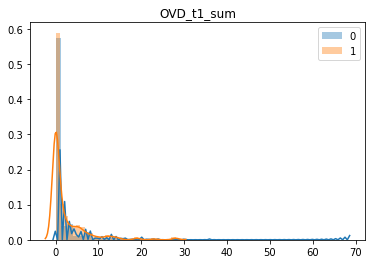

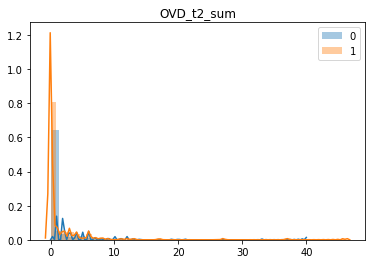

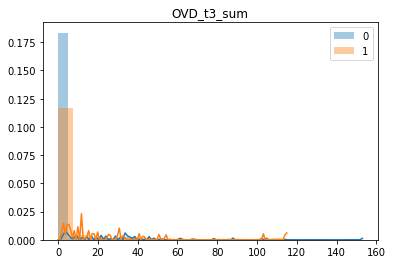

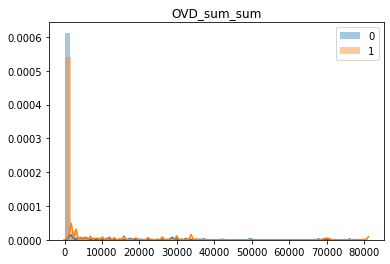

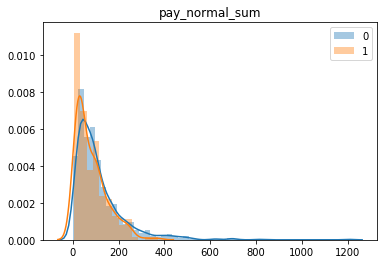

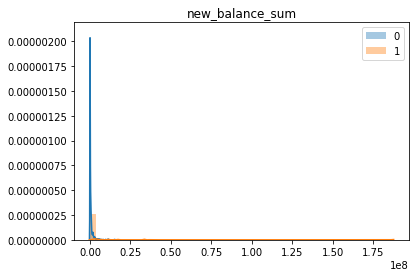

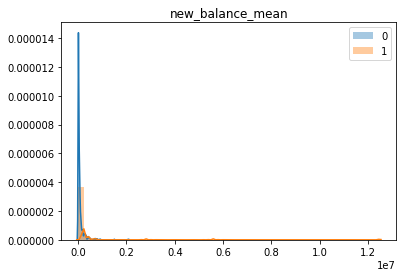

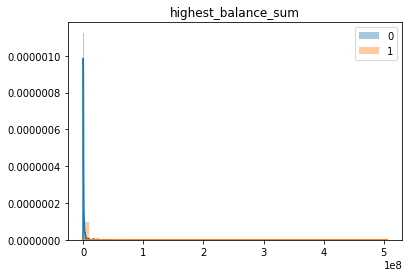

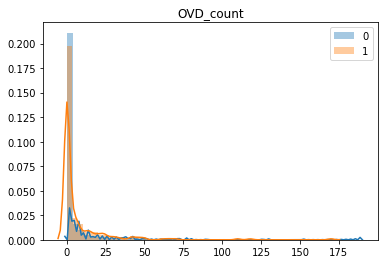

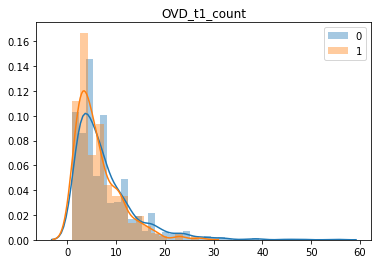

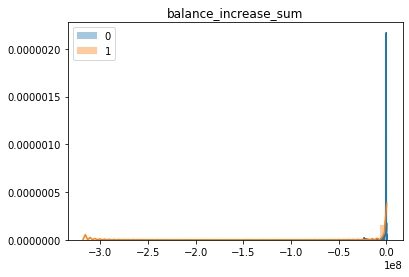

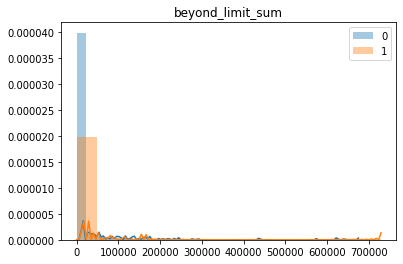

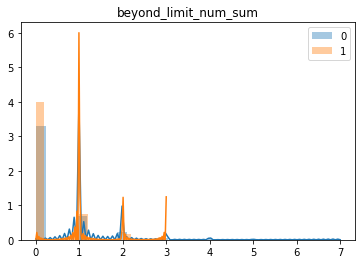

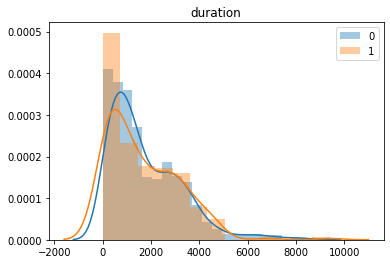

In [31]:
# Let's examine the distribution of the features from the payment history data
continuous1 = ['OVD_t1_sum', 'OVD_t2_sum', 'OVD_t3_sum', 'OVD_sum_sum', 'pay_normal_sum', 'new_balance_sum', 'new_balance_mean', 'highest_balance_sum', 'OVD_count', 'OVD_t1_count', 'balance_increase_sum', 'beyond_limit_sum', 'beyond_limit_num_sum', 'duration']
for i, col in enumerate(continuous1):
    label0 = comb.loc[comb['label']==0]
    label1 = comb.loc[comb['label']==1]
    plt.figure(i)
    ax = sns.distplot(label0[[col]], label='0')
    ax = sns.distplot(label1[[col]], label='1')
    plt.legend()
    ax.set_title(col)

## 3.3 Correlation Matrix

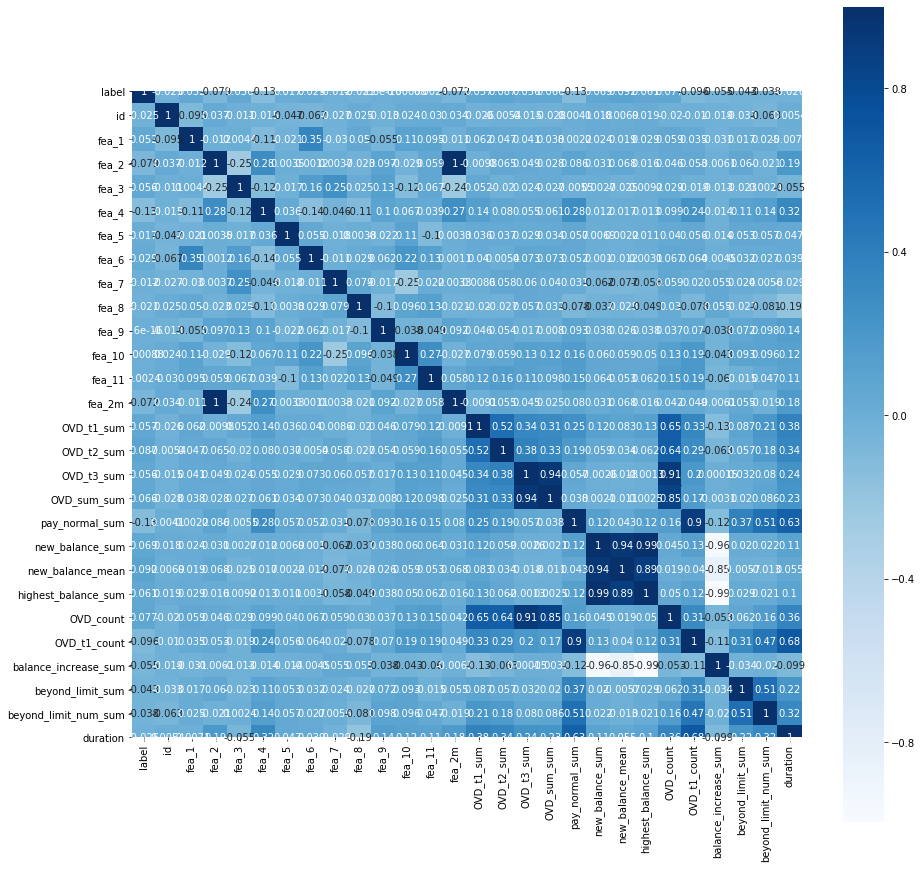

In [32]:
plt.figure(figsize=(15,15))
sns.heatmap(comb.corr(), square=True, annot=True, cmap="Blues")

## 3.4 Model Performance Based on Customer and Payment Data

Training ROC_AUC Score: 0.780
Training Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       674
           1       0.00      0.00      0.00       169

    accuracy                           0.80       843
   macro avg       0.40      0.50      0.44       843
weighted avg       0.64      0.80      0.71       843

Testing ROC_AUC Score: 0.658
Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       226
           1       0.00      0.00      0.00        56

    accuracy                           0.80       282
   macro avg       0.40      0.50      0.44       282
weighted avg       0.64      0.80      0.71       282



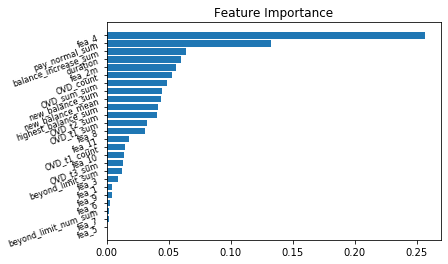

<Figure size 2160x2160 with 0 Axes>

In [33]:
X = comb.drop(['label', 'id', 'fea_2'], axis=1)
y = comb['label']
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X, y, stratify=y, random_state=0)
test(X_trainc, X_testc, y_trainc, y_testc)

With the addition of features extracted from the payment history data, there is an improvement in the ROC_AUC score for the test data as compared to just using the customer data alone. 

Training ROC_AUC Score: 0.873
Training Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       674
           1       0.80      0.78      0.79       674

    accuracy                           0.79      1348
   macro avg       0.79      0.79      0.79      1348
weighted avg       0.79      0.79      0.79      1348

Testing ROC_AUC Score: 0.672
Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       226
           1       0.36      0.43      0.39        56

    accuracy                           0.74       282
   macro avg       0.61      0.62      0.61       282
weighted avg       0.75      0.74      0.75       282



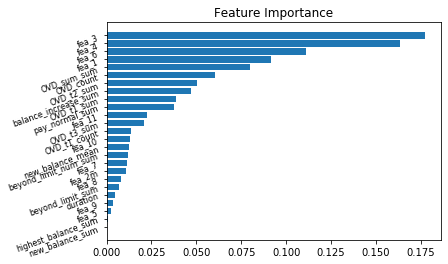

<Figure size 2160x2160 with 0 Axes>

In [34]:
over = SMOTE(sampling_strategy=1)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
X_c, y_c = pipeline.fit_resample(X_trainc, y_trainc)
test(X_c, X_testc, y_c, y_testc)

When oversampling is performed on the minority class, the ROC_AUC score and f1-score have improved as well. 

# 4. Modelling

## 4.1 Hyperparameters Optimisation

GridSearchCV is used to find the best hyperparameters for RandomForestClassifier.

In [35]:
X = comb.drop(['label', 'id', 'fea_2'], axis=1)
y = comb['label']
kf = KFold(n_splits=5, random_state=0, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
rf = RandomForestClassifier(n_estimators=100, random_state=0)
cross_val_score(rf, X_train, y_train, cv=kf, scoring='roc_auc').mean()


0.6489055633757996

In [37]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1]
}

new_params = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}
imba_pipeline = make_pipeline(SMOTE(), RandomForestClassifier(random_state=0))
#cross_val_score(imba_pipeline, X_train, y_train, scoring='recall', cv=kf)
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='roc_auc', return_train_score=True)
grid_imba.fit(X_train, y_train);
print(grid_imba.best_params_)
print(grid_imba.best_score_)

{'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__n_jobs': -1}
0.654989889576343


## 4.2 Final Model

In [40]:
X_final = comb.drop(['label', 'id', 'fea_2'], axis=1)
y_final = comb['label']
X_trainf, X_testf, y_trainf, y_testf = train_test_split(X_final, y_final, stratify=y_final, random_state=0)
over = SMOTE(sampling_strategy=1)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
Xoverf, yoverf = pipeline.fit_resample(X_trainf, y_trainf)
rff = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=5, random_state=0)
rff.fit(Xoverf, yoverf)
y_pred_trainf = rff.predict_proba(Xoverf)
y_pred_testf = rff.predict_proba(X_testf)
score_auc_trainf = roc_auc_score(yoverf, y_pred_trainf[:,1])
score_auc_testf = roc_auc_score(y_testf, y_pred_testf[:,1])
score_trainf = classification_report(yoverf, y_pred_trainf[:,1].round())
score_testf = classification_report(y_testf, y_pred_testf[:,1].round())
print("Training ROC_AUC Score: {:.3f}".format(score_auc_trainf))
print("Training Classification Report: \n{}".format(score_trainf))
print("Testing ROC_AUC Score: {:.3f}".format(score_auc_testf))
print("Testing Classification Report: \n{}".format(score_testf))

Training ROC_AUC Score: 0.955
Training Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       674
           1       0.89      0.88      0.88       674

    accuracy                           0.88      1348
   macro avg       0.88      0.88      0.88      1348
weighted avg       0.88      0.88      0.88      1348

Testing ROC_AUC Score: 0.696
Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       226
           1       0.38      0.39      0.39        56

    accuracy                           0.75       282
   macro avg       0.61      0.62      0.62       282
weighted avg       0.76      0.75      0.75       282

